## Chapter 17 - Metric Predicted Variable with One Metric Predictor

- [17.2 - Robust Linear Regression](#17.2---Robust-Linear-Regression)
- [17.3 - Hierarchical Regression on Individuals within Groups](#17.3---Hierarchical-Regression-on-Individuals-within-Groups)
- [17.4 - Quadratic Trend and Weighted Data](#17.4---Quadratic-Trend-and-Weighted-Data)

In [1]:
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore') 
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from matplotlib import gridspec
from IPython.display import Image
import theano.tensor as tt

%matplotlib inline
# plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,theano,matplotlib,seaborn,scipy

pandas    : 1.2.1
numpy     : 1.19.5
pymc3     : 3.11.0
theano    : 1.1.0
matplotlib: 3.3.3
seaborn   : 0.11.1
scipy     : 1.6.0



In [3]:
def plot_grid(trace, data, sd_h, sd_w, mean_h, mean_w):
    """This function creates plots like figures 17.3 and 17.4 in the book."""
    
    plt.figure(figsize=(13,13))
    
    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[:2,1:5])
    ax2 = plt.subplot(gs[2,:2])
    ax3 = plt.subplot(gs[2,2:4])
    ax4 = plt.subplot(gs[2,4:6])
    ax5 = plt.subplot(gs[3,:2])
    ax6 = plt.subplot(gs[3,2:4])                     
    ax7 = plt.subplot(gs[3,4:6])
        
    # Scatter plot of the observed data
    ax1.scatter(data.height, data.weight, s=40, linewidths=1, facecolor='none', edgecolor='k', zorder=10)
    ax1.set_xlabel('height', fontdict=f_dict)
    ax1.set_ylabel('height', fontdict=f_dict)
    ax1.set(xlim=(0,80), ylim=(-350,250))

    # Convert parameters to original scale
    beta0 = trace['beta0']*sd_w+mean_w-trace['beta1']*mean_h*sd_w/sd_h
    beta1 = trace['beta1']*(sd_w/sd_h)
    sigma = trace['sigma']*sd_w
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])
    
    # Credible regression lines from posterior
    hpd_interval = np.round(az.hdi(B.values, hdi_prob=.95), decimals=3)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:])] 
    xrange = np.arange(0, data.height.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax1.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)    
        
    # Intercept
    az.plot_posterior(beta0, point_estimate='mode', ax=ax2, color=color, hdi_prob=.95)
    ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)
    ax2.set_title('Intercept', fontdict={'weight':'bold'})

    # Slope
    az.plot_posterior(beta1, point_estimate='mode', ax=ax3, color=color, ref_val=0, hdi_prob=.95)
    ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax3.set_title('Slope', fontdict={'weight':'bold'})
    
    # Scatter plot beta1, beta0
    ax4.scatter(beta1, beta0, edgecolor=color, facecolor='none', alpha=.6)
    ax4.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax4.set_ylabel(r'$\beta_0$', fontdict=f_dict)
    
    # Scale
    az.plot_posterior(sigma, point_estimate='mode', ax=ax5, color=color, hdi_prob=.95)
    ax5.set_xlabel(r'$\sigma$', fontdict=f_dict)
    ax5.set_title('Scale', fontdict={'weight':'bold'})

    # Normality
    az.plot_posterior(np.log10(trace['nu']), point_estimate='mode', ax=ax6, color=color, hdi_prob=.95)
    ax6.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax6.set_title('Normality', fontdict={'weight':'bold'})
    
    # Scatter plot normality, sigma
    ax7.scatter(np.log10(trace['nu']), sigma,
                edgecolor=color, facecolor='none', alpha=.6)
    ax7.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax7.set_ylabel(r'$\sigma$', fontdict=f_dict)
    
    plt.tight_layout()
    
    return(plt.gcf());

In [4]:
def plot_cred_lines(dist, x, sd_x, sd_y, mean_x, mean_y, ax):
    """This function plots credibility lines."""
    # Convert parameters to original scale
    beta0 = dist[:,0]*sd_y+mean_y-dist[:,1]*mean_x*sd_y/sd_x
    beta1 = dist[:,1]*(sd_y/sd_x)
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])

    # Credible regression lines from posterior
    hpd_interval = np.round(pm.hpd(B.values, alpha=0.05), decimals=3)
    hpd_interval = pm.hpd(B.values, alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:])] 
    xrange = np.arange(x.min()*.95, x.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)    

In [5]:
def plot_quad_credlines(dist, x, sd_x, sd_y, mean_x, mean_y, ax):
    """This function plots quadratic credibility lines."""
    # Convert parameters to original scale
    beta0 = dist[:,0]*sd_y+mean_y-dist[:,1]*mean_x*sd_y/sd_x + dist[:,2]*mean_x**2*sd_y/sd_x**2
    beta1 = dist[:,1]*sd_y/sd_x - 2*dist[:,2]*mean_x*sd_y/sd_x**2
    beta2 = dist[:,2]*sd_y/sd_x**2
    B = pd.DataFrame(np.c_[beta0, beta1, beta2], columns=['beta0', 'beta1', 'beta2'])

    # Credible regression lines from posterior
    hpd_interval = pm.hpd(B.values, alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:]) & B.beta2.between(*hpd_interval[2,:])] 
    xrange = np.arange(x.min()-1, x.max()+2)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange+B_hpd.iloc[i,2]*xrange**2, c=color, alpha=.6, zorder=0)    

### 17.2 - Robust Linear Regression

#### Model (Kruschke, 2015)

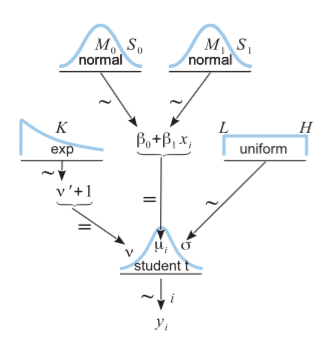

In [6]:
Image('images/fig17_2.png', width=400)

#### N = 30

In [7]:
df_n30 = pd.read_csv('data/HtWtData30.csv')
df_n30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    30 non-null     int64  
 1   height  30 non-null     float64
 2   weight  30 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 848.0 bytes


In [8]:
df_n30.head(3)

,male,height,weight
0,0,64.0,136.4
1,0,62.3,215.1
2,1,67.9,173.6


In [9]:
# Standardize the data
sd_h = df_n30.height.std()
mean_h = df_n30.height.mean()
zheight = (df_n30.height - mean_h)/sd_h

sd_w = df_n30.weight.std()
mean_w = df_n30.weight.mean()
zy = (df_n30.weight - mean_w)/sd_w

In [10]:
sd_h, mean_h, sd_w, mean_w

(4.201074027972578, 66.98333333333333, 31.702569604690247, 154.01333333333335)

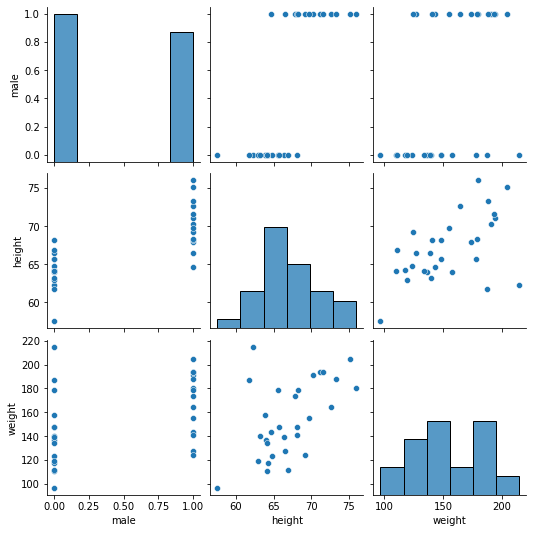

In [11]:
sns.pairplot(df_n30);

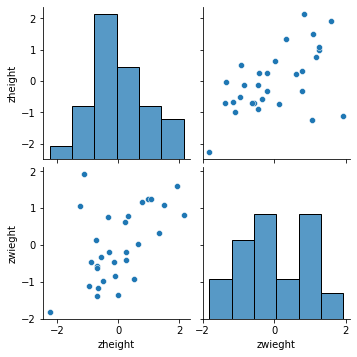

In [12]:
sns.pairplot(pd.DataFrame({'zheight': zheight, 'zwieght':zy}));

#### Data Standardization
- When the scale of the two axes are the same, that is the distance in x and the distance in y are the same, then distribution or shape of the scatter plot of the data points is not istropic; this is no good for numerical computation.
- Standardization alleviates this situation and helps the computation to result in stable (robust) numerical calculations.
- Without standardization, it is not practically easy to define non-committal prior models. For example, you need a good guess for $\beta_0$ which is the bias corresponds to  height being 0. If the prior is already given, then no worries.
- $\beta_1$ is the slope of the regression line. Can you guess? One possible way is to compute an ML/MAP estimate.

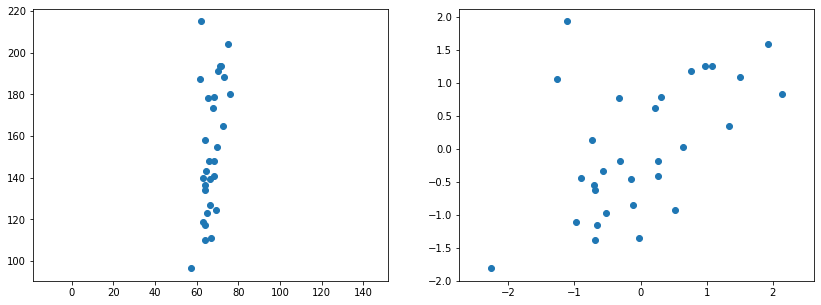

In [13]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
ax = axes[0]
ax.scatter(df_n30.height, df_n30.weight)
ax.axis('equal')  # the same scale along x & y axis
ax = axes[1]
ax.scatter(zheight, zy)
ax.axis('equal');

In [14]:
zheight.shape, zy.shape

((30,), (30,))

#### Model

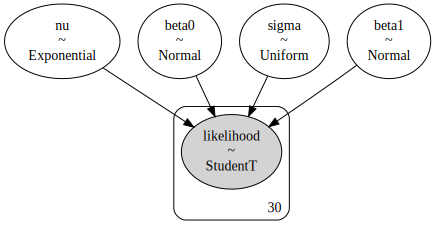

In [15]:
with pm.Model() as model:
    
    beta0 = pm.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pm.Normal('beta1', mu=0, tau=1/10**2)
    mu =  beta0 + beta1*zheight
    
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    nu = pm.Exponential('nu', 1/29.)
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zy)

pm.model_to_graphviz(model)

In [16]:
with model:
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, beta1, beta0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


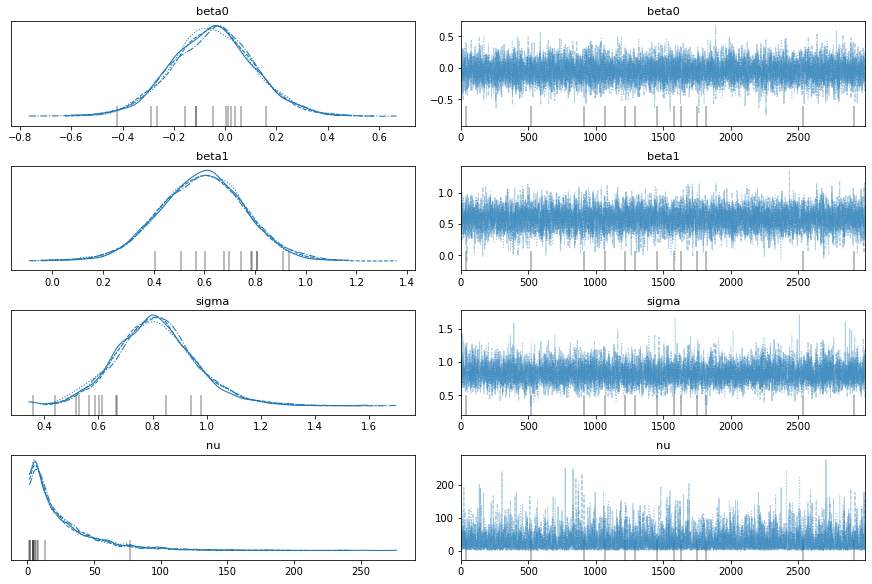

In [17]:
az.plot_trace(trace);

#### Figure 17.3

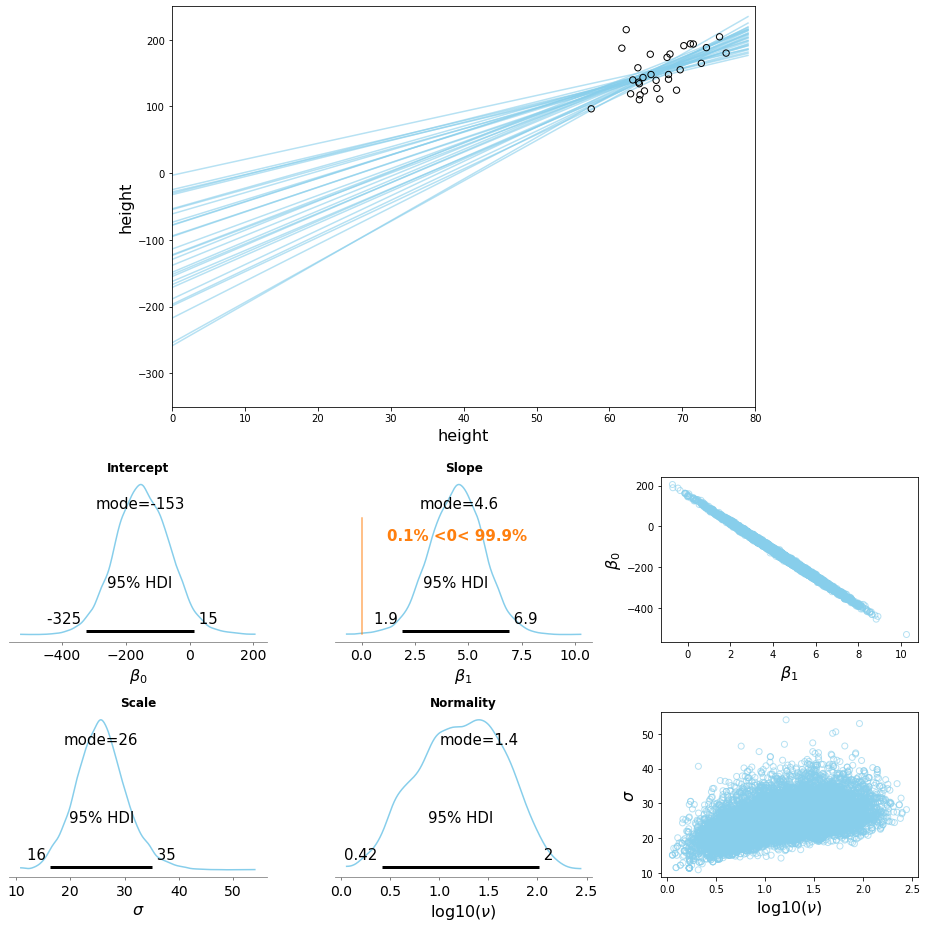

In [18]:
plot_grid(trace, df_n30, sd_h, sd_w, mean_h, mean_w);

#### N = 300

In [20]:
df_n300 = pd.read_csv('data/HtWtData300.csv')
df_n300.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    300 non-null    int64  
 1   height  300 non-null    float64
 2   weight  300 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.2 KB


In [21]:
# Standardize the data
sd_h2 = df_n300.height.std()
mean_h2 = df_n300.height.mean()
zheight2 = (df_n300.height - mean_h2)/sd_h2

sd_w2 = df_n300.weight.std()
mean_w2 = df_n300.weight.mean()
zy2 = (df_n300.weight - mean_w2)/sd_w2

df_n300['zheight'] = zheight2
df_n300['zweight'] = zy2

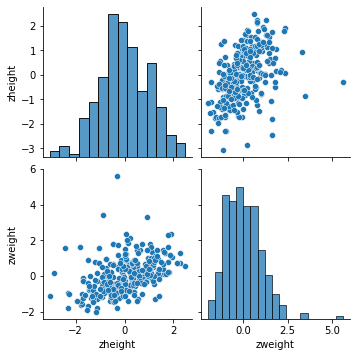

In [22]:
sns.pairplot(df_n300[['zheight', 'zweight']])

#### Model

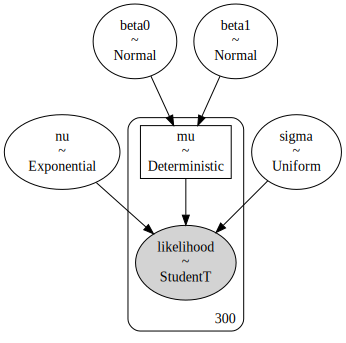

In [29]:
with pm.Model() as model2:
    
    beta0 = pm.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pm.Normal('beta1', mu=0, tau=1/10**2)
    mu =  pm.Deterministic('mu', beta0 + beta1*zheight2)
    
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    nu = pm.Exponential('nu', 1/29.)
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zy2)  

pm.model_to_graphviz(model2)

In [30]:
with model2:
    trace2 = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, beta1, beta0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


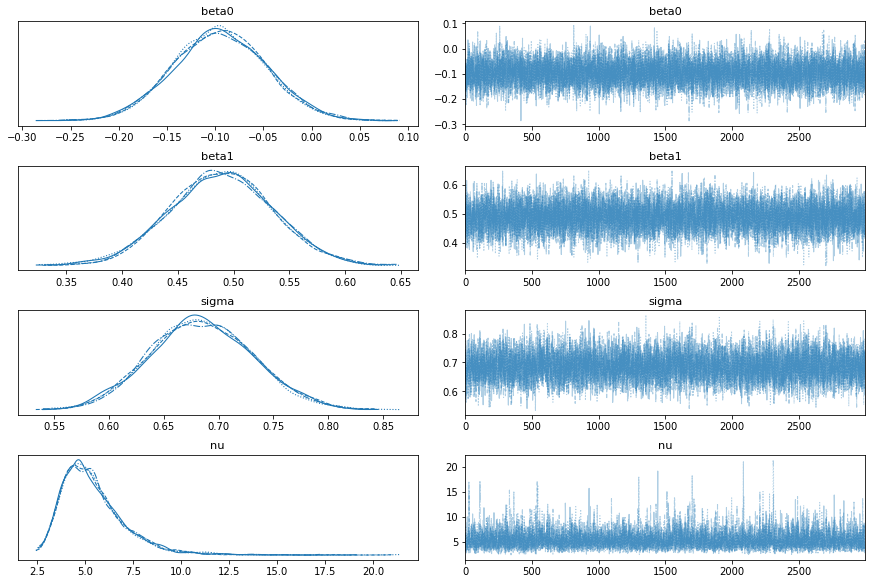

In [32]:
az.plot_trace(trace2, var_names=['beta0', 'beta1', 'sigma', 'nu']);

#### Figure 17.4

- I guess the intercept should be translated to the mean location without scalinging. It will provide some insight.

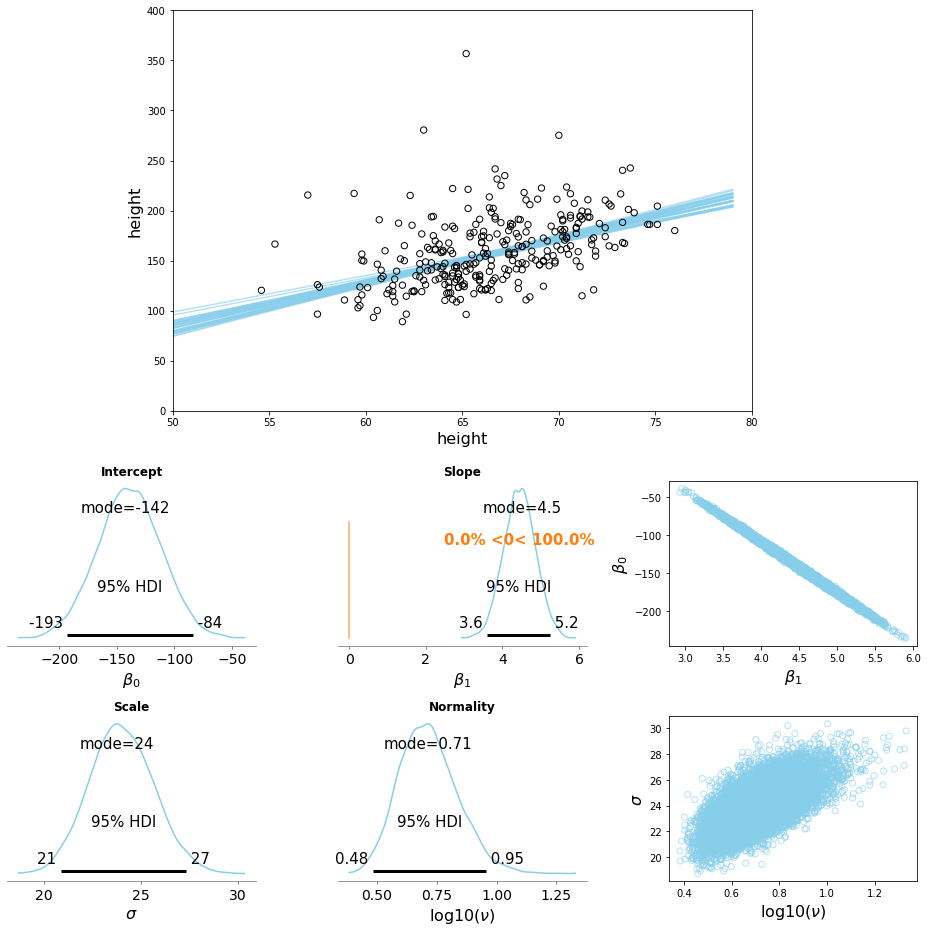

In [33]:
grid = plot_grid(trace2, df_n300, sd_h2, sd_w2, mean_h2, mean_w2)
grid.axes[0].set_xlim(50,80)
grid.axes[0].set_ylim(0,400);

#### Posterior Predictive Check
$$
    p(y|Y, x) = \sum_i p(y | \theta_i, x) p(\theta_i|Y,X)
$$


In [34]:
# get sample from observation distribution. Naming 'likelihood' was a not a good idea
ppc = pm.sample_posterior_predictive(trace2, model=model2)
ppc['likelihood'].shape

(12000, 300)

In [35]:
trace2.varnames

['beta0', 'beta1', 'sigma_interval__', 'nu_log__', 'mu', 'sigma', 'nu']

**Homework**
* Since we have three parameters for T distribution, we may draw random samples from `stats.t`.

#### Display the PPC results
1. We have 300 measurements {x_i, i=1,...,300}.
2. For each x_i, we have 12000 samples $y_{k|i}$ from 12000 $\theta_k$s, k=1,...,12000.

(300,) (12000, 300)


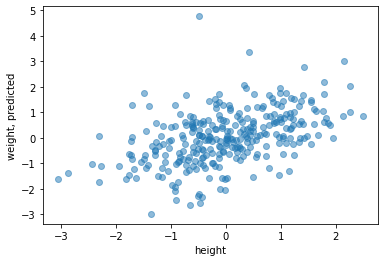

In [37]:
x = df_n300.zheight.values  # predictor
y_ki = ppc['likelihood']
print(x.shape, y_ki.shape)

plt.plot(x, y_ki[0,:], 'o', alpha=.5);
plt.xlabel('height')
plt.ylabel('weight, predicted');

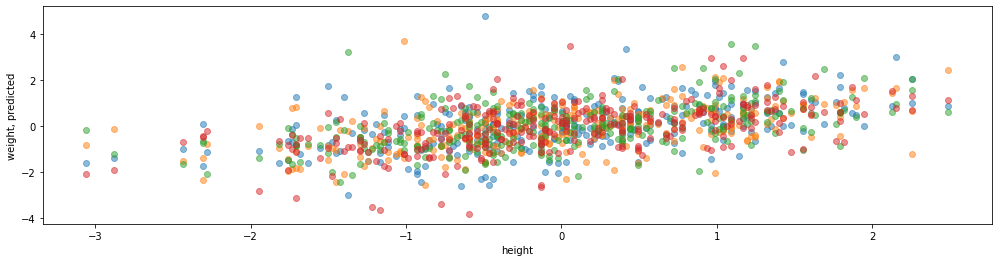

In [40]:
# more samples for each x
plt.figure(figsize=(17,4))
plt.plot(x, y_ki[0,:], 'o', alpha=.5);
plt.plot(x, y_ki[1,:], 'o', alpha=.5);
plt.plot(x, y_ki[2,:], 'o', alpha=.5);
plt.plot(x, y_ki[3,:], 'o', alpha=.5);

plt.xlabel('height')
plt.ylabel('weight, predicted');

y_ki.T:  (300, 12000)


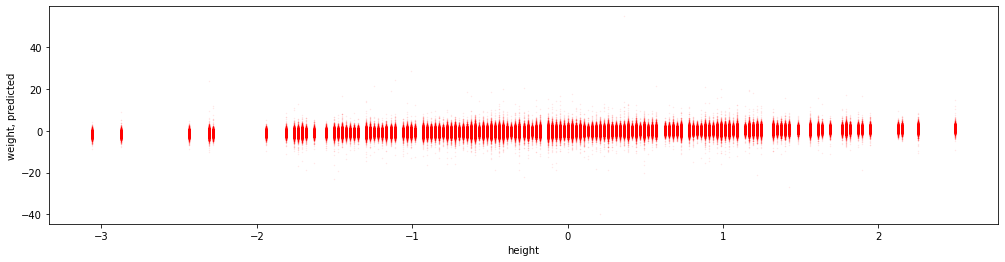

In [46]:
# every sample
plt.figure(figsize=(17, 4))
plt.plot(x, y_ki.T, 'o', alpha=.1, color='#ff0000', markersize=.41);
print('y_ki.T: ', y_ki.T.shape)

plt.xlabel('height')
plt.ylabel('weight, predicted');

yo:  (300, 12000)


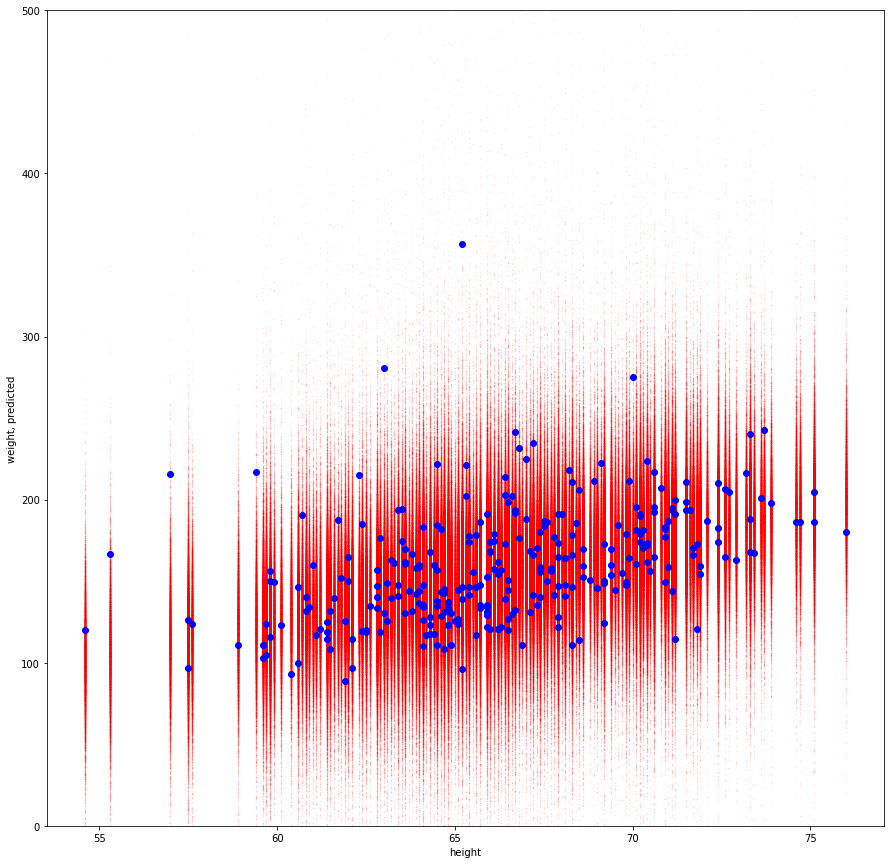

In [61]:
# rescale back to original domain
xo = x * sd_h2 + mean_h2
yo = y_ki.T * sd_w2 + mean_w2

plt.figure(figsize=(15, 15))
plt.plot(xo, yo, 'o', alpha=.1, color='#ff0000', markersize=.41);
plt.plot(df_n300.height, df_n300.weight, 'o', color='b')
print('yo: ', yo.shape)

plt.ylim(0, 500)
plt.xlabel('height')
plt.ylabel('weight, predicted');

In [57]:
yo.ravel().min(), yo.ravel().max()

(-1235.1021934736307, 2082.2241382792745)

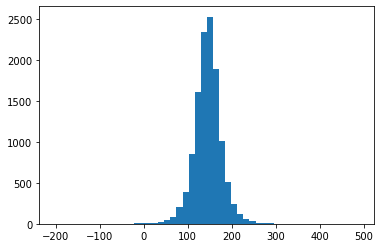

In [55]:
plt.hist(yo[0,:], bins=50);

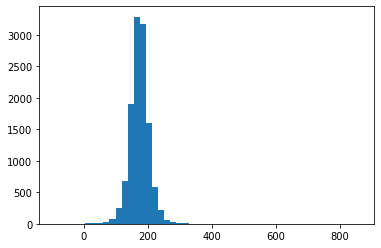

In [56]:
plt.hist(yo[-1,:], bins=50);

---
### 17.3 - Hierarchical Regression on Individuals within Groups

#### Model (Kruschke, 2015)

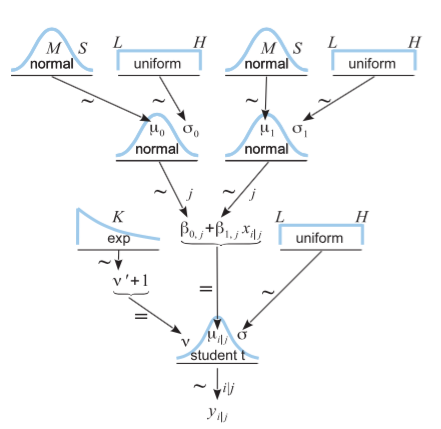

In [20]:
Image('images/fig17_6.png', width=500)

In [21]:
df_HRegr = pd.read_csv('data/HierLinRegressData.csv')
df_HRegr.Subj = df_HRegr.Subj.astype('category')
df_HRegr.Subj = df_HRegr.Subj.cat.as_ordered()
df_HRegr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
Subj    132 non-null category
X       132 non-null float64
Y       132 non-null float64
dtypes: category(1), float64(2)
memory usage: 3.1 KB


In [22]:
df_HRegr.head()

,Subj,X,Y
0,1,60.2,145.6
1,1,61.5,157.3
2,1,61.7,165.6
3,1,62.3,158.8
4,1,67.6,196.1


In [23]:
subj_idx = df_HRegr.Subj.cat.codes.values
subj_codes = df_HRegr.Subj.cat.categories
n_subj = len(subj_codes)

print('Number of groups: {}'.format(n_subj))

Number of groups: 25


In [24]:
# Standardize the data
sd_x3 = df_HRegr.X.std()
mean_x3 = df_HRegr.X.mean()
zx3 = (df_HRegr.X - mean_x3)/sd_x3

sd_y3 = df_HRegr.Y.std()
mean_y3 = df_HRegr.Y.mean()
zy3 = (df_HRegr.Y - mean_y3)/sd_y3

#### Model
Reparameterization of hierarchical models generally results in much more efficient and faster sampling.  
See http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/ and  
http://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html

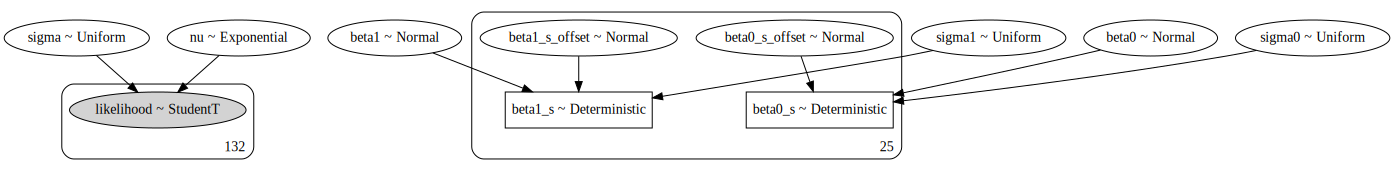

In [25]:
with pm.Model() as model3:
    
    beta0 = pm.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pm.Normal('beta1', mu=0, tau=1/10**2)
    sigma0 = pm.Uniform('sigma0', 10**-3, 10**3)
    sigma1 = pm.Uniform('sigma1', 10**-3, 10**3)
    
    # The below parameterization resulted in a lot of divergences.
    #beta0_s = pm.Normal('beta0_s', mu=beta0, sd=sigma0, shape=n_subj)
    #beta1_s = pm.Normal('beta1_s', mu=beta1, sd=sigma1, shape=n_subj)
    
    beta0_s_offset = pm.Normal('beta0_s_offset', mu=0, sd=1, shape=n_subj)
    beta0_s = pm.Deterministic('beta0_s', beta0 + beta0_s_offset * sigma0)
    
    beta1_s_offset = pm.Normal('beta1_s_offset', mu=0, sd=1, shape=n_subj)
    beta1_s = pm.Deterministic('beta1_s', beta1 + beta1_s_offset * sigma1)
        
    mu =  beta0_s[subj_idx] + beta1_s[subj_idx] * zx3
    
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    nu = pm.Exponential('nu', 1/29.)
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zy3)  

pm.model_to_graphviz(model3)

In [26]:
with model3:
    trace3 = pm.sample(3000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, beta1_s_offset, beta0_s_offset, sigma1, sigma0, beta1, beta0]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:26<00:00, 193.48draws/s]
The number of effective samples is smaller than 25% for some parameters.


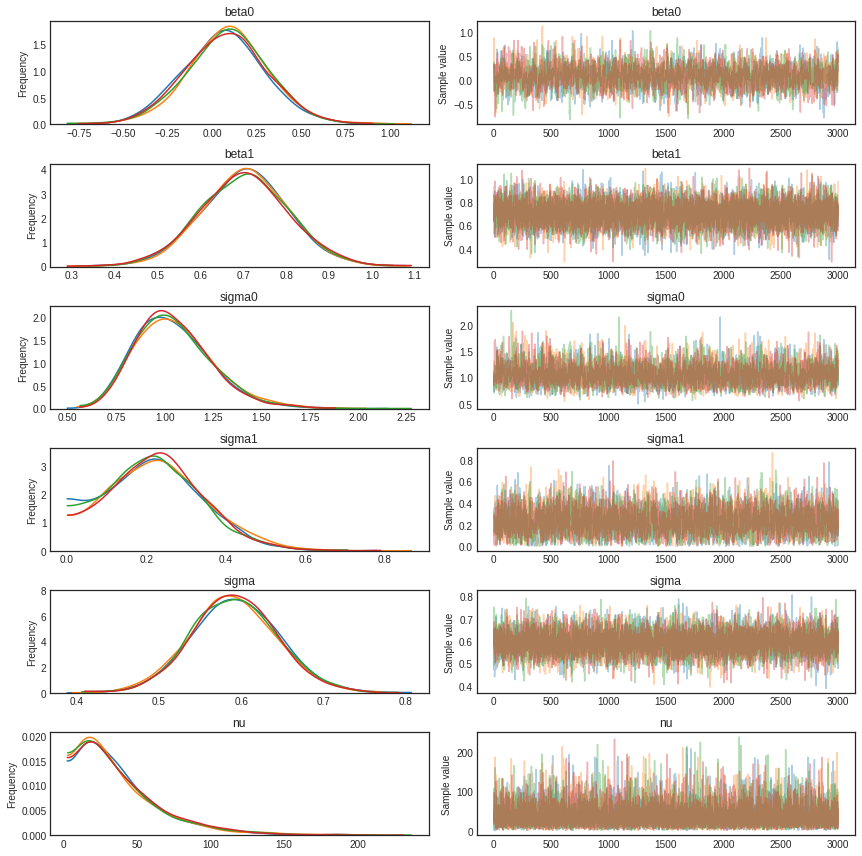

In [27]:
pm.traceplot(trace3, ['beta0', 'beta1', 'sigma0', 'sigma1', 'sigma', 'nu']);

#### Figure 17.5

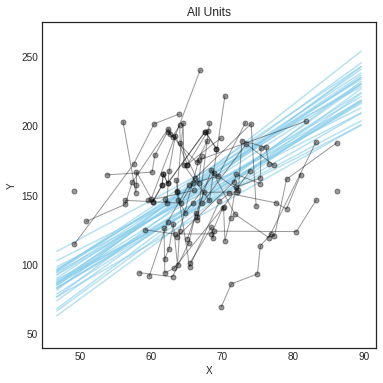

In [28]:
plt.figure(figsize=(6,6))
ax = plt.gca()

df_HRegr.groupby('Subj').apply(lambda group: ax.plot(group.X, group.Y, 'k-o', lw=1, markersize=5, alpha=.4))
ax.set(xlabel='X', ylabel='Y', ylim=(40,275), title='All Units');

plot_cred_lines(np.c_[trace3['beta0'], trace3['beta1']], df_HRegr.X, sd_x3, sd_y3, mean_x3, mean_y3, ax)

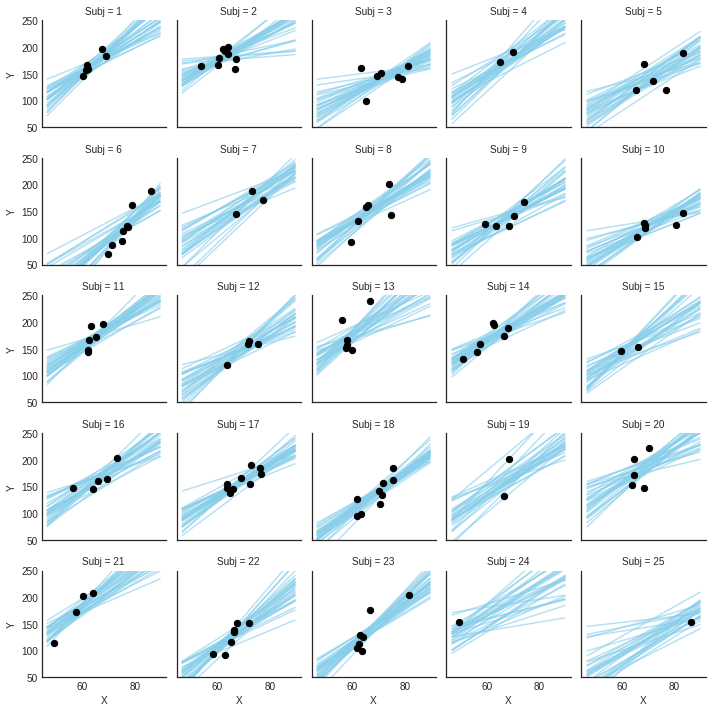

In [29]:
fg = sns.FacetGrid(df_HRegr, col='Subj', col_wrap=5, ylim=(50,250), height=2)
fg.map(plt.scatter, 'X', 'Y', color='k', s=40)

for i, ax in enumerate(fg.axes):
    plot_cred_lines(np.c_[trace3['beta0_s'][:,i], trace3['beta1_s'][:,i]],
                    df_HRegr.X, sd_x3, sd_y3, mean_x3, mean_y3, ax)

### 17.4 - Quadratic Trend and Weighted Data

In [30]:
df_income = pd.read_csv('data/IncomeFamszState3yr.csv', skiprows=1, dtype={'State':'category'})
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 4 columns):
FamilySize      312 non-null int64
State           312 non-null category
MedianIncome    312 non-null int64
SampErr         312 non-null int64
dtypes: category(1), int64(3)
memory usage: 10.6 KB


In [31]:
df_income.head()

,FamilySize,State,MedianIncome,SampErr
0,2,Alabama,48177,581
1,3,Alabama,53323,1177
2,4,Alabama,64899,1170
3,5,Alabama,59417,2446
4,6,Alabama,54099,3781


In [32]:
state_idx = df_income.State.cat.codes.values
state_codes = df_income.State.cat.categories
n_states = len(state_codes)

print('Number of states: {}'.format(n_states))

Number of states: 52


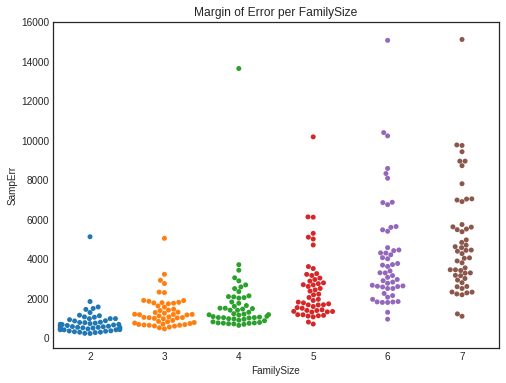

In [33]:
mean_fs = df_income.FamilySize.mean()
sd_fs = df_income.FamilySize.std()
z_fs = (df_income.FamilySize - mean_fs)/sd_fs

mean_income = df_income.MedianIncome.mean()
sd_income = df_income.MedianIncome.std()
z_income = (df_income.MedianIncome - mean_income)/sd_income

mean_error = df_income.SampErr.mean()
z_error = df_income.SampErr / mean_error

# There are fewer large-sized families than small-sized families, making the medians for income
# for the former group noisier. We can modulate the noise parameter with the margin of error. 
plt.figure(figsize=(8,6))
sns.swarmplot(x='FamilySize', y='SampErr', data=df_income)
plt.title('Margin of Error per FamilySize');

#### Model

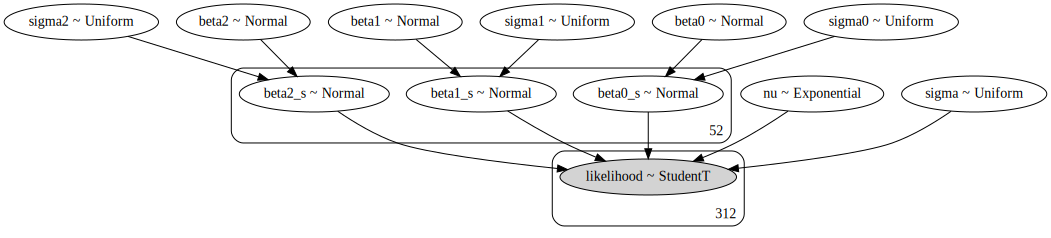

In [34]:
with pm.Model() as model4:
       
    beta0 = pm.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pm.Normal('beta1', mu=0, tau=1/10**2)
    beta2 = pm.Normal('beta2', mu=0, tau=1/10**2)
    
    sigma0 = pm.Uniform('sigma0', 10**-3, 10**3)
    sigma1 = pm.Uniform('sigma1', 10**-3, 10**3)
    sigma2 = pm.Uniform('sigma2', 10**-3, 10**3)
        
    beta0_s = pm.Normal('beta0_s', mu=beta0, sd=sigma0, shape=n_states)
    beta1_s = pm.Normal('beta1_s', mu=beta1, sd=sigma1, shape=n_states)
    beta2_s = pm.Normal('beta2_s', mu=beta2, sd=sigma2, shape=n_states)
    
    mu =  beta0_s[state_idx] + beta1_s[state_idx] * z_fs + beta2_s[state_idx] * z_fs**2
    
    nu = pm.Exponential('nu', 1/29.)
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    
    # Modulate the noise parameter with the margin of error.
    w_sigma = tt.as_tensor(z_error)*sigma
        
    likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sd=w_sigma, observed=z_income)

pm.model_to_graphviz(model4)

In [35]:
with model4:
    trace4 = pm.sample(3000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, beta2_s, beta1_s, beta0_s, sigma2, sigma1, sigma0, beta2, beta1, beta0]
Sampling 4 chains: 100%|██████████| 14000/14000 [01:55<00:00, 121.35draws/s]
The number of effective samples is smaller than 25% for some parameters.


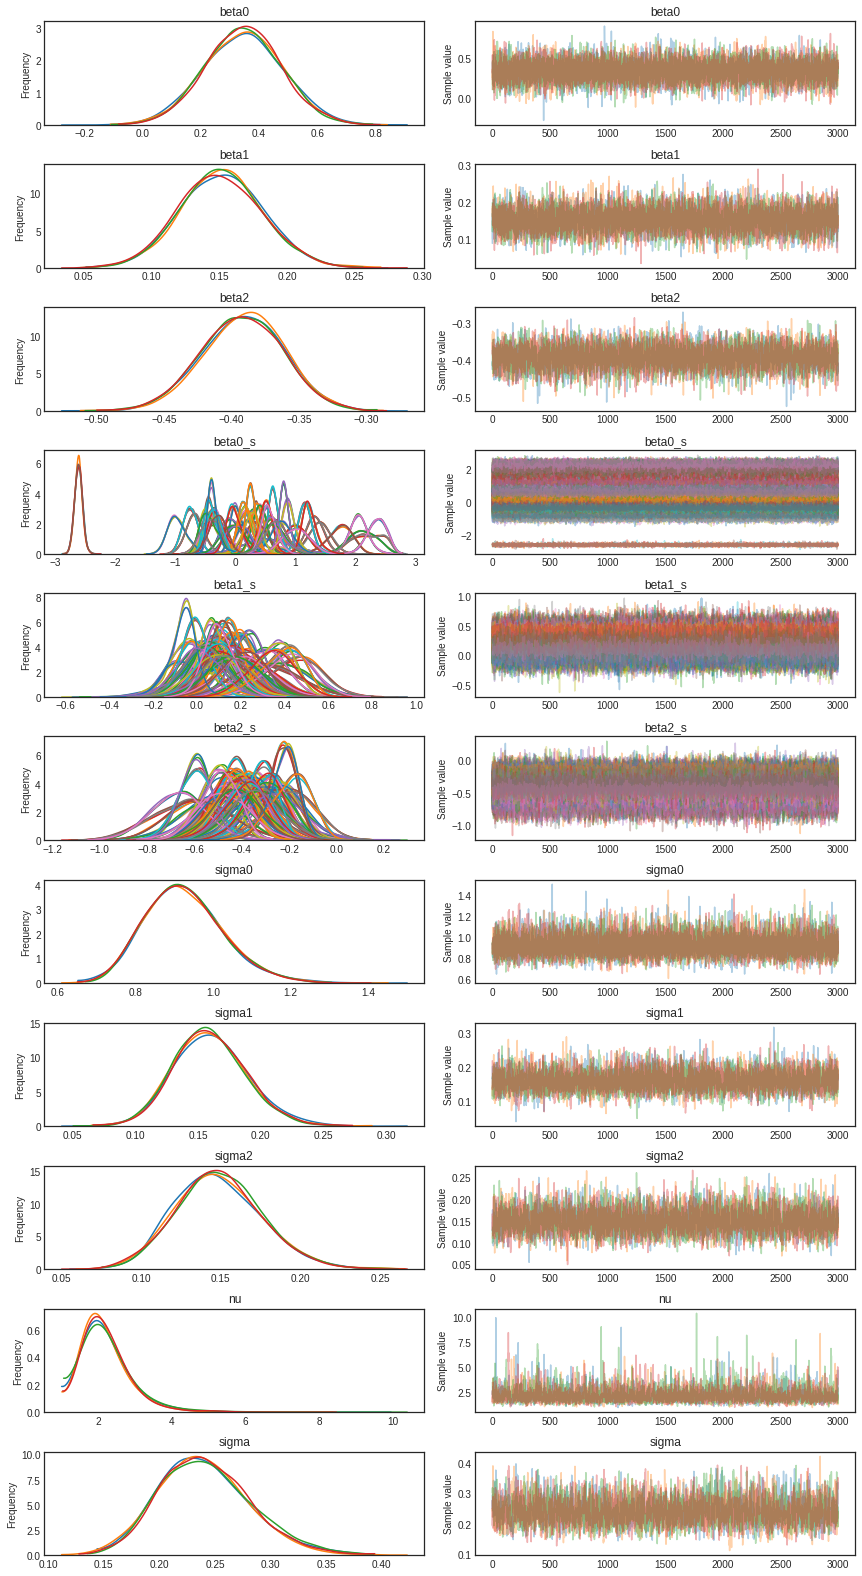

In [36]:
pm.traceplot(trace4);

#### Figure 17.7

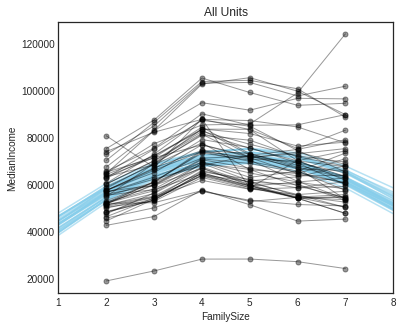

In [37]:
plt.figure(figsize=(6,5))
ax = plt.gca()

df_income.groupby('State').apply(lambda group: ax.plot(group.FamilySize,
                                                       group.MedianIncome,
                                                       'k-o', lw=1, markersize=5, alpha=.4))
ax.set(xlabel='FamilySize', ylabel='MedianIncome', xlim=(1,8), title='All Units');

plot_quad_credlines(np.c_[trace4['beta0'], trace4['beta1'], trace4['beta2']],
                    df_income.FamilySize, sd_fs, sd_income, mean_fs, mean_income, ax)

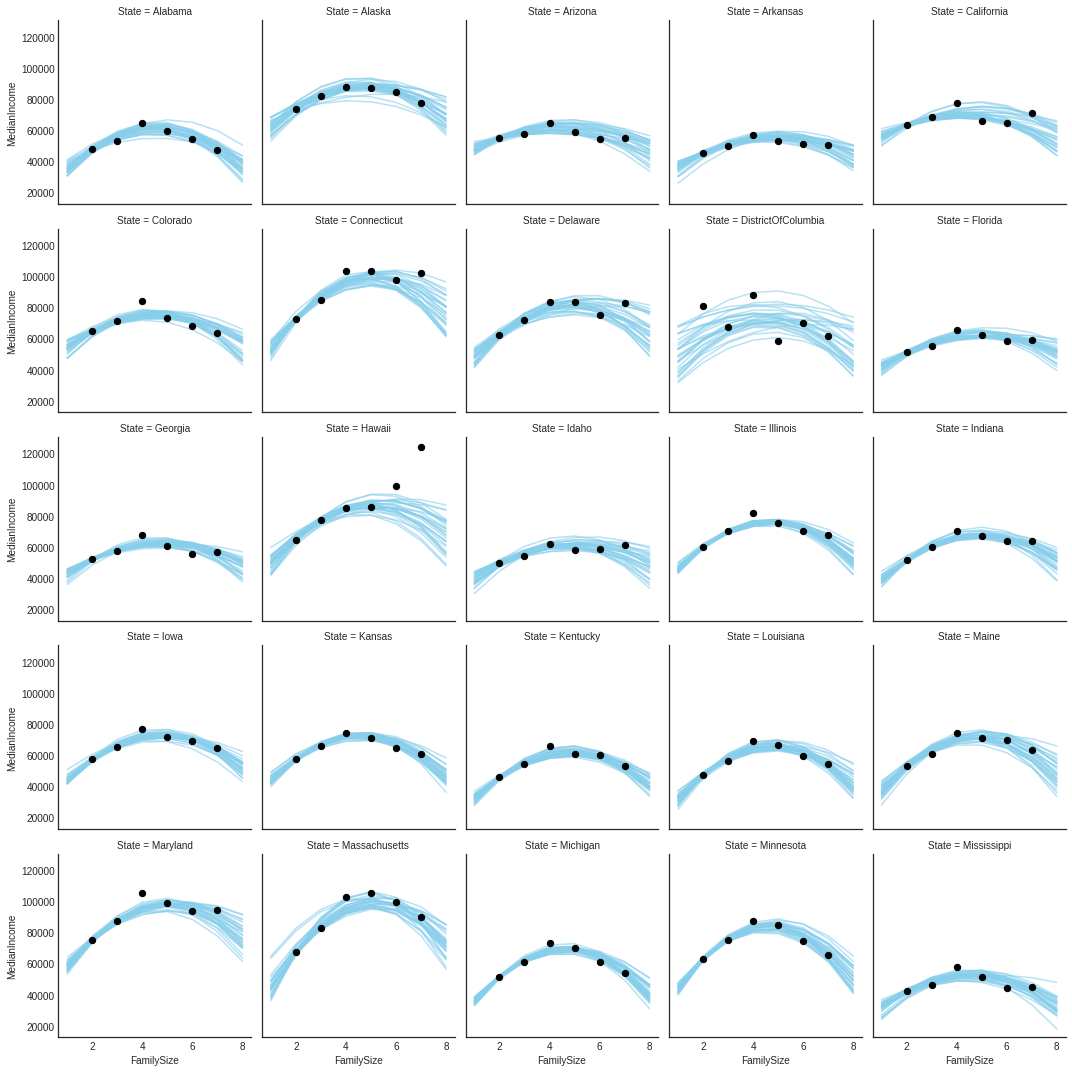

In [38]:
# The book shows the data for the first 25 States.
df_income_subset = df_income[df_income.State.isin(df_income.State.cat.categories[:25])]
df_income_subset.State.cat.remove_unused_categories(inplace=True)

fg = sns.FacetGrid(df_income_subset, col='State', col_wrap=5)
fg.map(plt.scatter, 'FamilySize', 'MedianIncome', color='k', s=40);

for i, ax in enumerate(fg.axes):
    plot_quad_credlines(np.c_[trace4['beta0_s'][:,i], trace4['beta1_s'][:,i], trace4['beta2_s'][:,i]],
                        df_income_subset.FamilySize, sd_fs, sd_income, mean_fs, mean_income, ax)